# **DATA COLLECTION**

In [ ]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from pprint import pprint

url_species = 'https://xeno-canto.org/api/2/recordings?query=troglodytes+troglodytes'
response = requests.get(url_species)

# Parse the JSON response
data = response.json()

# Extract the "recordings" list from the data
recordings_list = data['recordings']

# Create a DataFrame from the "recordings" list
df = pd.DataFrame(recordings_list)

# Write the DataFrame to a CSV file
df.to_csv('bird_dataset2.csv', index=False)

# Print the first few rows of the DataFrame (optional)
pprint(df.head())

In [ ]:
def download(url, file_name):
    # Send a GET request to download the audio file
    response = requests.get(url)
    file_name = f"{file_name}"

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Save the audio content to a local file
        with open(file_name, "wb") as f:
            f.write(response.content)
        print("Audio downloaded successfully.")
    else:
        print(f"Failed to download audio. Status code: {response.status_code}")

In [ ]:
for file, file_name in zip(df["file"], df["file-name"]):
    download(file, file_name)
    print("Downloaded {file_name}".format(file_name=file_name))


# **GROUP DATA**

In [ ]:
#dot run it again
import os
import shutil
import pandas as pd

# Define paths
input_dir = '/content/drive/MyDrive/AudioBad/all'  # Directory where the audio files are currently located
output_dir = '/content/drive/MyDrive/AudioBad/org'  # Directory where you want to organize the files

# Read the CSV file
csv_file = '/content/drive/MyDrive/AudioBad/merged_file.csv'
df = pd.read_csv(csv_file)

# Iterate through each row in the CSV file and organize the files
for index, row in df.iterrows():
    audio_file = row['file-name']  # Assuming 'audio_file' is the column with the audio file names
    bird_species = row['sp']  # Assuming 'bird_species' is the column with bird species labels

    # Construct source and destination paths
    source_path = os.path.join(input_dir, audio_file)
    destination_path = os.path.join(output_dir, bird_species)

    # Create the destination folder if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)

    # Move the audio file to the destination folder
    shutil.move(source_path, os.path.join(destination_path, os.path.basename(audio_file)))

print("Audio files organized based on bird species.")


In [ ]:
#Loading audio files to get to know what sort of audio we are dealing with

import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file
audio_file = "/content/drive/MyDrive/AudioBad/bird_song/americana/XC686584-03-11-2021 16e47 Ema BARRA.mp3"
audio, sr = librosa.load(audio_file)

# **Audio Preprocessing with Librosa**

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt


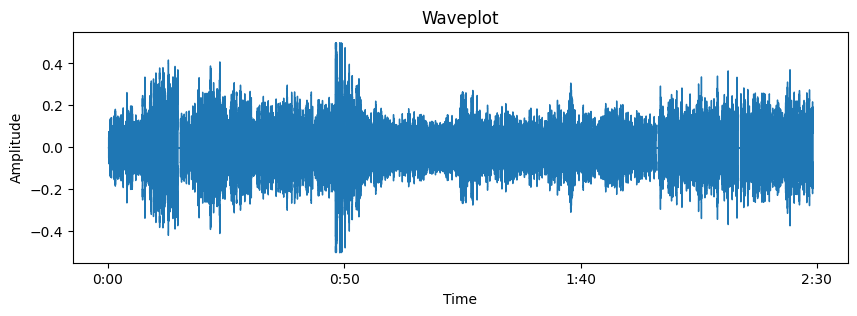

In [2]:
#waveform
aud="/content/drive/MyDrive/All1/major/CRYVAR08.mp3"


signal,sr =librosa.load(aud,sr=22050)
plt.figure(figsize=(10, 3))
librosa.display.waveshow(signal,sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveplot")
plt.show()




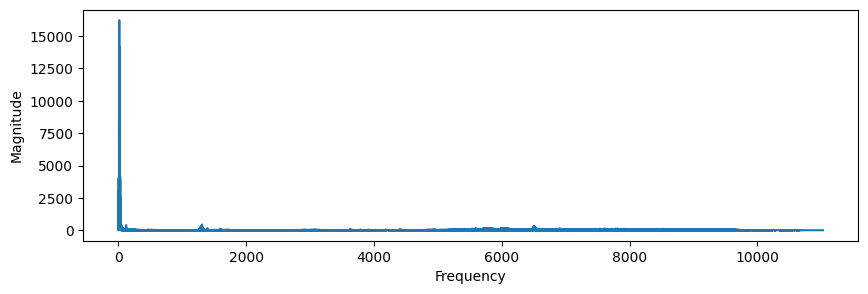

In [3]:
#Fast Fourier Transform(FFT)

fft=np.fft.fft(signal)
magnitude=np.abs(fft)#for scaling
frequency=np.linspace(0, sr, len(magnitude))

lft_freq=frequency[:int(len(frequency)/2)]
lft_mag=magnitude[:int(len(frequency)/2)]

plt.figure(figsize=(10, 3))
plt.plot(lft_freq, lft_mag)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

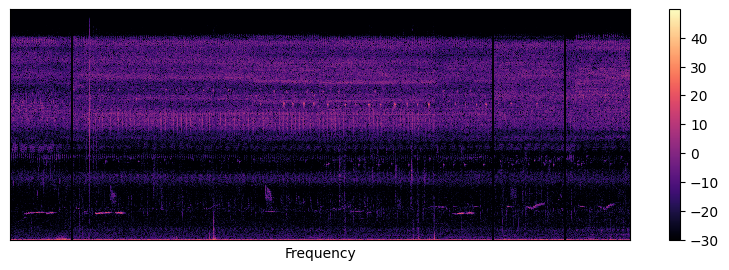

In [4]:
#stft
n_fft=2048
hop_length=512

stft=librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram=np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)#scaling

plt.figure(figsize=(10, 3))
librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length )
plt.xlabel("Time")
plt.xlabel("Frequency")
plt.colorbar()
plt.show()

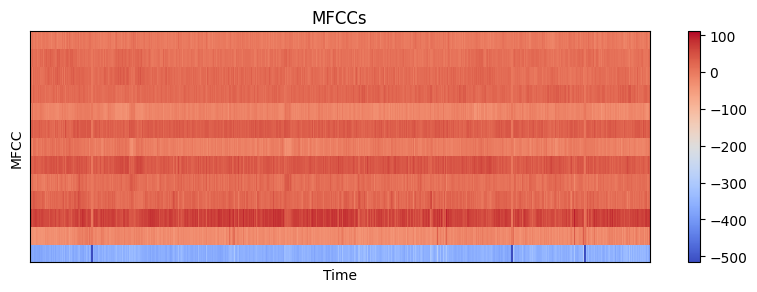

In [5]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load audio file and compute the MFCCs
audio_path = "/content/drive/MyDrive/All1/major/CRYVAR08.mp3"
y, sr = librosa.load(audio_path)
n_fft = 2048
hop_length = 512
MFCCs = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# Create a new figure and set the size
plt.figure(figsize=(10, 3))  # Adjust the size as per your preference

# Display the MFCCs
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.title("MFCCs")
plt.show()


# **FEATURE EXTRACTION**

In [ ]:
import os
import math
import json
DATASET_PATH="/content/drive/MyDrive/All1"
JSON_PATH="/content/drive/MyDrive/All1/data.json"

SAMPLE_RATE=22050
DURATION=15
SAMPLE_PER_TRACK=SAMPLE_RATE * DURATION

def save_mfcc(dataset_path,json_path,n_mfcc=13, n_fft=2048,hop_length=512,num_segments=5):
  #dictionary to store data
  data={
      "mapping":[],
      "mfcc":[],
      "labels":[]
  }

  num_samples_per_segment=int(SAMPLE_PER_TRACK/num_segments)
  expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment/hop_length)


  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    #such that we aint at the root level
    if dirpath is not dataset_path:

      #save the semantic label
      dirpath_components = dirpath.split("/") #species/taoi=>["species","taoi"]
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      print("\nProcessing {}".format(semantic_label))

      #processing files for a specific species
      for f in filenames:
        #load audio files
        file_path =os.path.join(dirpath,f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        #process segments extracting mfcc and storing data

        for s in range(num_segments):
          start_sample = num_samples_per_segment * s
          finish_sample = start_sample + num_samples_per_segment


          mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                            sr=sr,
                            n_fft=n_fft,
                            n_mfcc=n_mfcc,
                            hop_length=hop_length)

          mfcc=mfcc.T

          #store mfcc for segment if it has expected length
          if len(mfcc)==expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
            print("{}, segment:{}".format(file_path, s))

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)


if __name__ == "__main__":
  save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)




Processing maura
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:0
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:1
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:2
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:3
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:4
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:5
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:6
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:7
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:8
/content/drive/MyDrive/All1/maura/XC529078-papa.mp3, segment:9
/content/drive/MyDrive/All1/maura/XC246018-PYRLNT13.mp3, segment:0
/content/drive/MyDrive/All1/maura/XC246018-PYRLNT13.mp3, segment:1
/content/drive/MyDrive/All1/maura/XC246018-PYRLNT13.mp3, segment:2
/content/drive/MyDrive/All1/maura/XC246018-PYRLNT13.mp3, segment:3
/content/drive/MyDrive/All1/maura/XC246018-PYRLNT13.mp3, segment:4
/content/drive/My

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


/content/drive/MyDrive/All1/obsoletus/XC699403-Crypturellus obsoletus150622 (online-audio-converter.com).mp3, segment:0
/content/drive/MyDrive/All1/obsoletus/XC699403-Crypturellus obsoletus150622 (online-audio-converter.com).mp3, segment:1
/content/drive/MyDrive/All1/obsoletus/XC699403-Crypturellus obsoletus150622 (online-audio-converter.com).mp3, segment:2
/content/drive/MyDrive/All1/obsoletus/XC699403-Crypturellus obsoletus150622 (online-audio-converter.com).mp3, segment:3
/content/drive/MyDrive/All1/obsoletus/XC698117-Crypturellus_obsoletus-4172523.mp3, segment:0
/content/drive/MyDrive/All1/obsoletus/XC698117-Crypturellus_obsoletus-4172523.mp3, segment:1
/content/drive/MyDrive/All1/obsoletus/XC698117-Crypturellus_obsoletus-4172523.mp3, segment:2
/content/drive/MyDrive/All1/obsoletus/XC698117-Crypturellus_obsoletus-4172523.mp3, segment:3
/content/drive/MyDrive/All1/obsoletus/XC698117-Crypturellus_obsoletus-4172523.mp3, segment:4
/content/drive/MyDrive/All1/obsoletus/XC698117-Crypture

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=96
  warnings.warn(


/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:1
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:2
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:3
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:4
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:5
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:6
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:7
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:8
/content/drive/MyDrive/All1/obsoletus/Crypturellus_obsoletus-746417.mp3, segment:9
/content/drive/MyDrive/All1/obsoletus/chamados inhambuguauu.mp3, segment:0
/content/drive/MyDrive/All1/obsoletus/chamados inhambuguauu.mp3, segment:1
/content/drive/MyDrive/All1/obsoletus/chamados inhambuguauu.mp3, segment:2
/content/drive/MyDrive/All1/

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=237
  warnings.warn(


/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:0
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:1
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:2
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:3
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:4
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:5
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:6
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:7
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:8
/content/drive/MyDrive/All1/obsoletus/XC389227-140914_16_Cryp_obsoletus_Set14_16e50.mp3, segment:9
/content/d

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1128
  warnings.warn(


/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:0
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:1
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:2
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:3
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:4
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:5
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:6
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:7
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:8
/content/drive/MyDrive/All1/tao/XC597722-Tinamos tao_Carajas_1030.WAV_E.mp3, segment:9
/content/drive/MyDrive/All1/tao/XC217695-CRYSOU29.mp3, segment:0
/content/drive/MyDrive/All1/tao/XC217695-CRYSOU29.mp3, segment:1


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1332
  warnings.warn(


/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:0
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:1
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:2
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:3
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:4
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:5
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:6
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:7
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:8
/content/drive/MyDrive/All1/tao/XC557622-Tinamus tao DCB 625-18a.mp3, segment:9
/content/drive/MyDrive/All1/tao/XC557618-Tinamus tao DCB 625-16d.mp3, segment:0
/content/drive/MyDrive/All1/tao/XC557618-Tinamus tao DCB 625-16d.mp3, segment:1
/content/drive/MyDrive/All1/tao/XC557618

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1588
  warnings.warn(


/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:0
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:1
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:2
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:3
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:4
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:5
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:6
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:7
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:8
/content/drive/MyDrive/All1/tao/B363-2-150_26-01-2011_Tinamus_taoBD.mp3, segment:9
/content/drive/MyDrive/All1/tao/XC483178-Tinamus tao_Rio Azul_1032.mp3, segment:0
/content/drive/MyDrive/All1/tao/XC483178-Tinamus tao_Rio Azul_1032.mp3, segment:1
/conte

# **CNN ARCH**

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import MaxPool2D, BatchNormalization, Conv2D
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import pickle

DATA_PATH ="/content/drive/MyDrive/data.json"

def load_data(data_path):
  #Loads training dataset from json file

  with open(data_path,"r") as fp:
    data = json.load(fp)

  X=np.array(data["mfcc"])
  y=np.array(data["labels"])
  return X, y


def prepare_datasets(test_size, validation_size):
  #Load data
  X, y =load_data(DATA_PATH)

  #Create train/test split
  X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=test_size)

  #create train/valid split
  X_train,X_validation,y_train,y_validation=train_test_split(X_train,y_train, test_size=validation_size)

  #3d array ->(130,3,1)
  X_train = X_train[...,np.newaxis] # will be a 4d array with num_samples inclusive
  X_test = X_test[...,np.newaxis]
  X_validation = X_validation[...,np.newaxis]

  return X_train,X_validation,X_test,y_train,y_validation,y_test


def build_model(input_shape):
  #create a model
  model=keras.Sequential()

  #1st Conv Layer
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  #2nd Conv Layer
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())

  #3rd Conv Layer
  model.add(Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())

  #flatten the output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64,activation='relu'))
  model.add(keras.layers.Dropout(0.3))# prevent over fitting

  #output layer
  model.add(keras.layers.Dense(15,activation='softmax'))

  return model


if __name__ =="__main__":
  #create train, validation and test sets
  X_train,X_validation,X_test,y_train,y_validation,y_test = prepare_datasets(0.25,0.2)

  #buid the CNN network
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  model = build_model(input_shape)

  #compile the CNN network
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

 # optimizer = keras.optimizersAdam(learning_rate=0.0001)
  model.compile(optimizer = optimizer,
                loss = "sparse_categorical_crossentropy",
                metrics = ['accuracy'])

  #train the CNN
  model.fit(X_train,y_train,validation_data=(X_validation, y_validation), batch_size=32, epochs=7)

  #evaluate the CNN on the test set
  test_error, test_accuracy = model.evaluate(X_test,y_test, verbose=1)
  print("Accuracy on the set is: {} ".format(test_accuracy))

   # Make predictions on the test set
  y_pred = model.predict(X_test)

    # Convert predicted probabilities to class labels
  y_pred_labels = np.argmax(y_pred, axis=1)

    # Calculate the accuracy manually
  accuracy = np.mean(y_pred_labels == y_test)
  print("Accuracy on the test set is: {:.2f}%".format(accuracy * 100))

# Save the model to an HDF5 file
model.save("bird_specie.h5")

print("Model saved to bird_species_model.h5")

#After running the script, you will have the trained model saved in the bird_species_model.pkl file,
# and you can load it later using pickle.load() for making predictions.







In [ ]:
# Evaluate the model on the test set
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy on the test set is: {:.2f}%".format(test_accuracy * 100))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the accuracy manually
accuracy = np.mean(y_pred_labels == y_test)
print("Accuracy on the test set is: {:.2f}%".format(accuracy * 100))


In [ ]:
def predict(model, X, y):
  X =X[np.newaxis, ...]

  #prediction =[[]]=> 2D array
  prediction = model.predict(X)#4D array ->

  #extract index with max value
  predicted_index = np.argmax(prediction, axis=1)
  print("Expected index: {}, Predicted index: {}".format(y,predicted_index))



  X= X_test[100]
  y= y_test[100]
  predict(model, X, y)

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.layers import MaxPool2D, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
import pickle

DATA_PATH ="/content/drive/MyDrive/data.json"

def load_data(data_path):
  #Loads training dataset from json file

  with open(data_path,"r") as fp:
    data = json.load(fp)

  X=np.array(data["mfcc"])
  y=np.array(data["labels"])
  return X, y


def prepare_datasets(test_size, validation_size):
  #Load data
  X, y =load_data(DATA_PATH)

  #Create train/test split
  X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=test_size)

  #create train/valid split
  X_train,X_validation,y_train,y_validation=train_test_split(X_train,y_train, test_size=validation_size)

  #3d array ->(130,3,1)
  X_train = X_train[...,np.newaxis] # will be a 4d array with num_samples inclusive
  X_test = X_test[...,np.newaxis]
  X_validation = X_validation[...,np.newaxis]

  return X_train,X_validation,X_test,y_train,y_validation,y_test


def build_model(input_shape):
  #create a model
  model=keras.Sequential()

  #1st Conv Layer
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())
  #2nd Conv Layer
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())

  #3rd Conv Layer
  model.add(Conv2D(32, (2, 2), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
  model.add(BatchNormalization())

  #flatten the output and feed it into dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(64,activation='relu'))
  model.add(keras.layers.Dropout(0.3))# prevent over fitting

  #output layer
  model.add(keras.layers.Dense(15,activation='softmax'))

  return model

def predict(model, X, y):
  X =X[np.newaxis, ...]

  #prediction =[[]]=> 2D array
  prediction = model.predict(X)#4D array ->

  #extract index with max value
  predicted_index = np.argmax(prediction, axis=1)
  print("Expected index: {}, Predicted index: {}".format(y,predicted_index))


if __name__ =="__main__":
  #create train, validation and test sets
  X_train,X_validation,X_test,y_train,y_validation,y_test=prepare_datasets(0.25,0.2)

  #buid the CNN network
  input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
  model = build_model(input_shape)

  #compile the CNN network
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

  model.compile(optimizer = optimizer,
                loss = "sparse_categorical_crossentropy",
                metrics = ['accuracy'])

  #train the CNN
  model.fit(X_train,y_train,validation_data=(X_validation, y_validation), batch_size=32, epochs=70)

  #evaluate the CNN on the test set
  test_error, test_accuracy = model.evaluate(X_test,y_test, verbose=1)
  print("Accuracy on the set is: {} ".format(test_accuracy))

   # Make predictions on the test set
  X= X_test[100]
  y= y_test[100]
  predict(model, X, y)






In [ ]:
import librosa

def extract_mfcc(file_path, n_mfcc=13, n_fft=2048, hop_length=512):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T  # Transpose to match the expected input shape

    return mfcc[np.newaxis, ...]  # Add a new axis for batching

new_audio_path = "/content/drive/MyDrive/All1/major/CRYVAR08.mp3"
new_mfcc = extract_mfcc(new_audio_path)
# Assuming you've already extracted new_mfcc from the new audio file
# new_mfcc.shape is (1, 6422, 13)

# Reshape the new_mfcc array to have the expected time steps (65)
new_mfcc_reshaped = new_mfcc[:, :65, :]

# Add the channel dimension (1) to match the model's input shape
new_mfcc_reshaped = new_mfcc_reshaped[..., np.newaxis]

# Now new_mfcc_reshaped.shape is (1, 65, 13, 1)



In [ ]:
from tensorflow.keras.models import load_model

model_path = "/content/bird_specie.h5"
loaded_model = load_model(model_path)


In [ ]:
def predict_species(model, mfcc):
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)
    return predicted_index

data_path="/content/drive/MyDrive/dat1.json"
with open(data_path,"r") as fp:
    data = json.load(fp)


predicted_species_index = predict_species(loaded_model, new_mfcc_reshaped)
predicted_species = data["mapping"][predicted_species_index[0]]
print("Predicted species:", predicted_species)

